# Calibrate Turbine Wind Directions to True North

Identify and correct wind direction measurement biases relative to true north for each wind turbine.

In [1]:
import warnings as wn
from pathlib import Path

import numpy as np
import pandas as pd
from floris.utilities import wrap_360

from flasc.data_processing import (
    dataframe_manipulations as dfm,
    energy_ratio_wd_bias_estimation as best,
    filtering as filt,
    northing_offset as nof,
)
from flasc.utilities import (
    floris_tools as ftools,
    optimization as flopt,
)

# from flasc import time_operations as fto
from flasc.utilities.utilities_examples import load_floris_smarteole as load_floris

In [2]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

In [3]:
# User settings
save_figures = True
plot_figures_in_notebook = True

# **Step 0**: Initial data pulldown
First, we import the filtered SMARTEOLE SCADA data from the postprocessed folder.

In [4]:
def load_data():
    root_path = Path.cwd()
    f = root_path / "postprocessed" / "df_scada_60s_wspowfiltered.ftr"
    df_scada = pd.read_feather(f)

    # # Optionally: downsample to [x] minute averages to speed up things
    # cols_angular = [c for c in df_scada if (("wd_" in c) or ("yaw_" in c))]
    # df_scada = fto.df_downsample(
    #     df_scada,
    #     cols_angular=cols_angular,
    #     window_width=td(seconds=600),
    # )

    return df_scada


df_scada_northing_uncalibrated = load_data()

# **Step 1**: Initialize FLORIS
Initialize FLORIS for the Sole du Moulin Vieux wind plant and load the large precalculated set of power production solutions created using the parallel computing interface in FLORIS.

In [5]:
# Now we load our precalculated grid of FLORIS solutions. Since our estimated SCADA
# data changes as we shift its wind direction, the predicted solutions
# according to FLORIS will also change. Therefore, we precalculate a grid
# of FLORIS solutions and insert that into the bias estimation class.
fm, _ = load_floris()

# Grab the precalculated FLORIS model solutions using the Gauss Curl Hybrid model
# from the 'setup_floris_model' directory
root_path = Path.cwd()
fn_approx = root_path / "precalculated_floris_solutions" / "df_fi_approx_gch.ftr"
if fn_approx.is_file():
    df_fm_approx = pd.read_feather(fn_approx)
else:
    raise UserWarning(
        "Please run '01_precalculate_floris_solutions.ipynb' for the appropriate wake models first."
    )

# **Step 2**: Cross-compare wind direction measurement biases between turbines
Cross-compare wind direction measurements and see if the relative bias between turbines is consistent. If the bias is consistent, then we know we can find a single offset value that would align the two turbines' northing offsets (the measured wind direction when the wind is actually form the north) for the entire time series. If this is not the case, one or both turbines likely experience jumps in their nacelle calibration throughout the time series. The current FLASC functionality is limited and cannot correct for this yet.

In [6]:
# Create a copy in which we mark the wd measurements of turbines with northing drift  as faulty
df_scada_marked_faulty_northing_drift = df_scada_northing_uncalibrated.copy()

turb_wd_consistency = nof.crosscheck_northing_offset_consistency(
    df=df_scada_marked_faulty_northing_drift, fm=fm, plot_figure=False
)
print(turb_wd_consistency)

# Mark wind direction measurements of turbines with inconsistent calibration as faulty
faulty_turbines = [not s == "clean" for s in turb_wd_consistency]
for ti in np.where(faulty_turbines)[0]:
    df_scada_marked_faulty_northing_drift["wd_{:03d}".format(ti)] = np.nan

2024-04-09 14:23:19 Matching curves for turbine 000...
2024-04-09 14:23:21    T001  T002  T003  T004  T005
0   0.0   0.0   0.0   0.0   0.0
2024-04-09 14:23:21 Matching curves for turbine 001...
2024-04-09 14:23:23    T002  T000  T003  T004  T005
0   0.0  -0.0   0.0   0.0   0.0
2024-04-09 14:23:23 Matching curves for turbine 002...
2024-04-09 14:23:24    T001  T003  T000  T004  T005
0  -0.0   0.0  -0.0   0.0  -2.0
2024-04-09 14:23:24 Matching curves for turbine 003...
2024-04-09 14:23:26    T004  T002  T005  T001  T006
0   0.0  -0.0   0.0  -0.0   0.0
2024-04-09 14:23:26 Matching curves for turbine 004...
2024-04-09 14:23:26    T005  T003  T006  T002  T001
0  -2.0  -0.0  -2.0  -0.0  -0.0
2024-04-09 14:23:26 Matching curves for turbine 005...
2024-04-09 14:23:27    T004  T006  T003  T002  T001
0   2.0   0.0  -0.0   2.0  -0.0
2024-04-09 14:23:27 Matching curves for turbine 006...
2024-04-09 14:23:28    T005  T004  T003  T002  T001
0  -0.0   2.0  -0.0   2.0   0.0
2024-04-09 14:23:28 Turbine

['clean', 'clean', 'clean', 'clean', 'clean', 'clean', 'clean']


Fortunately, the relative wind direction offsets between all turbines are zero. Therefore, we only need to identify a single offset for each turbine to complete the northing calibration.

# **Step 3**: Estimate the wind direction bias for a single wind turbine
By comparing the energy ratios for one or more turbines as a function of wind direction to the corresponding energy ratios as a function of wind direction predicted by FLORIS for different wind direction offsets, we can estimate the wind direction offset that aligns every turbine that was flagged as clean (i.e., not experiencing any changes in northing offset) with true north. If any turbines had experienced changes in their northing offsets during the time series, we wouldn't be able to correct their wind directions in this step.

Specifically, for the turbine of interest, we will compute the correlation between the energy ratios of the three closest turbines (relative to the set of unwaked turbines) as a function of the turbine of interest's wind direction to the corresponding energy ratios as a function of wind direction predicted by FLORIS for different wind direction offsets. The wind direction offset for which the average correlation for the three tubrines is maximized is treated as the wind direction bias (northing offset) for the turbien of interest.   

Here, we'll identify the northing offset for the first turbine classified as clean in the previous step. In this case, this is turbine 000. Therefore, we'll use the energy ratios for the three closest turbines (001, 002, and 003) to estimate the offset.

2024-04-09 14:23:28 Initializing a bias_estimation() object...
2024-04-09 14:23:28 Estimating the wind direction bias
2024-04-09 14:23:28     Initializing energy ratio inputs.
2024-04-09 14:23:28   Constructing energy table for wd_bias of -180.00 deg.


Initializing wd bias estimator object for turbine 000...


2024-04-09 14:23:28     Interpolating FLORIS predictions for dataframe.
2024-04-09 14:23:29     Determining energy ratios for test turbine = 001. WD bias: -180.000 deg.
2024-04-09 14:23:29     Determining energy ratios for test turbine = 002. WD bias: -180.000 deg.
2024-04-09 14:23:29     Determining energy ratios for test turbine = 003. WD bias: -180.000 deg.
2024-04-09 14:23:29     Initializing energy ratio inputs.
2024-04-09 14:23:29   Constructing energy table for wd_bias of -175.00 deg.
2024-04-09 14:23:29     Interpolating FLORIS predictions for dataframe.
2024-04-09 14:23:30     Determining energy ratios for test turbine = 001. WD bias: -175.000 deg.
2024-04-09 14:23:30     Determining energy ratios for test turbine = 002. WD bias: -175.000 deg.
2024-04-09 14:23:30     Determining energy ratios for test turbine = 003. WD bias: -175.000 deg.
2024-04-09 14:23:31     Initializing energy ratio inputs.
2024-04-09 14:23:31   Constructing energy table for wd_bias of -170.00 deg.
2024-0

Optimization terminated successfully.
         Current function value: -0.895097
         Iterations: 1
         Function evaluations: 2


2024-04-09 14:25:00     Determining energy ratios for test turbine = 001. WD bias: 0.000 deg.
2024-04-09 14:25:01     Determining energy ratios for test turbine = 002. WD bias: 0.000 deg.
2024-04-09 14:25:01     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.
2024-04-09 14:25:01     Initializing energy ratio inputs.
2024-04-09 14:25:01   Constructing energy table for wd_bias of 0.00 deg.
2024-04-09 14:25:01     Interpolating FLORIS predictions for dataframe.


Turbine 0. estimated bias = 0.0 deg.


2024-04-09 14:25:02     Determining energy ratios for test turbine = 001. WD bias: 0.000 deg.
2024-04-09 14:25:02     Determining energy ratios for test turbine = 002. WD bias: 0.000 deg.
2024-04-09 14:25:02     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.


Wind direction bias (northing offset) for first clean turbine: 0.000 deg


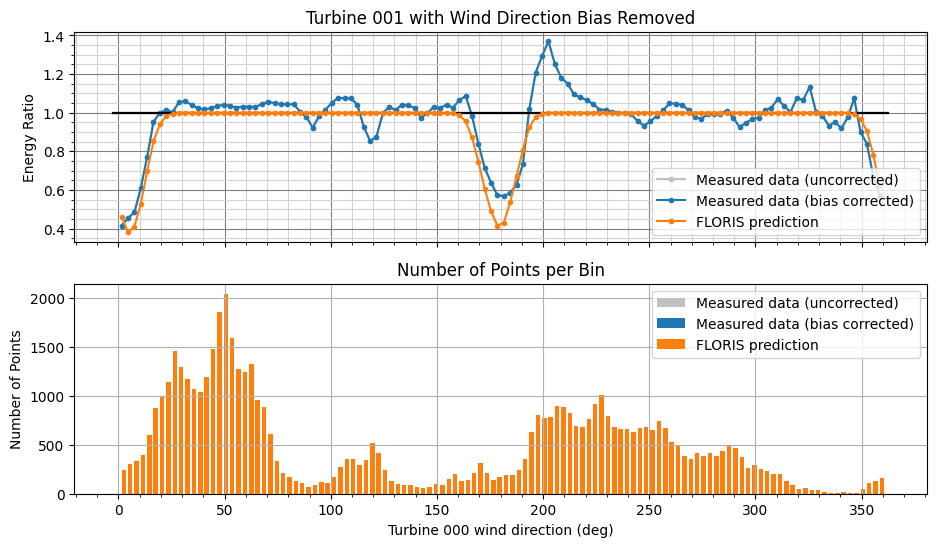

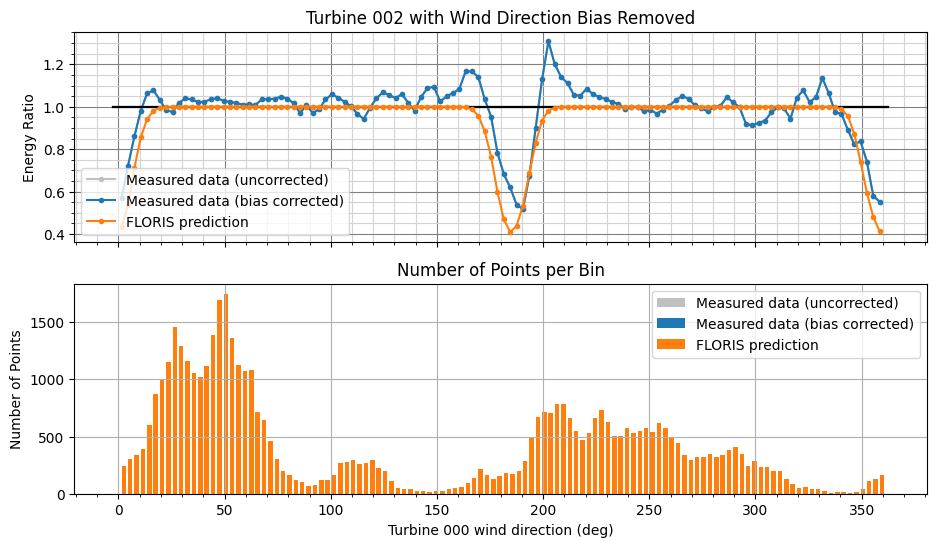

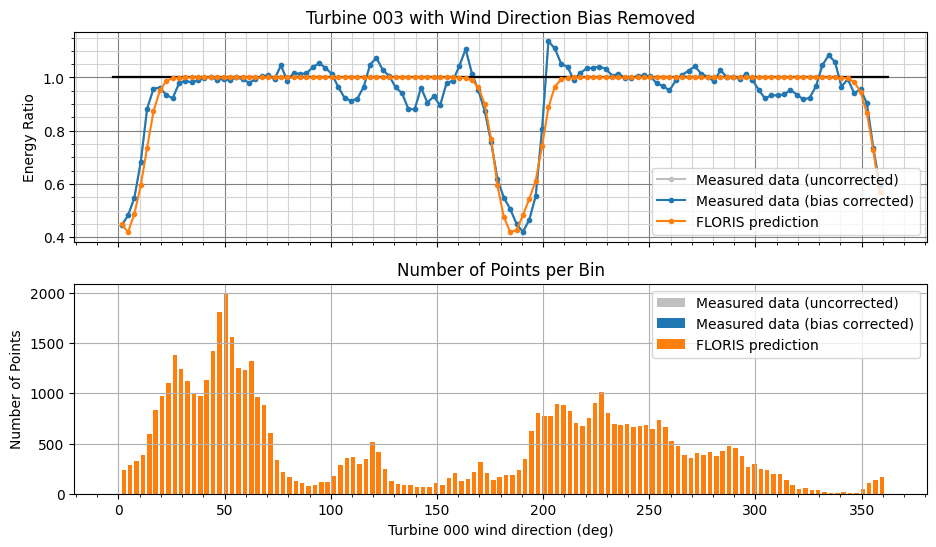

In [7]:
def get_bias_for_single_turbine(
    df, fm, ti, opt_search_range=[-180.0, 180.0], plot=True, figure_save_path=None
):
    print("Initializing wd bias estimator object for turbine %03d..." % ti)

    # Copy variables and unlink them
    df = df.copy()  # Unlink from input

    # Calculate which turbines are upstream for every wind direction
    df_upstream = ftools.get_upstream_turbs_floris(fm, wd_step=2.0)

    # We assign the total datasets "true" wind direction as equal to the wind
    # direction of the turbine which we want to perform northing calibration
    # on. In this case, turbine 'ti'.
    df = dfm.set_wd_by_turbines(df, [ti])

    # We define a function that calculates the freestream wind speed based
    # on a dataframe that is inserted. It does this based on knowing which
    # turbines are upstream for what wind directions, and then knowledge
    # of what the wind direction is for every row in the dataframe. However,
    # since the shift the "true" wind direction many times to estimate the
    # northing bias, we cannot precalculate this. It changes with every
    # northing bias guess. Hence, we must insert a function.
    def _set_ws_fun(df):
        return dfm.set_ws_by_upstream_turbines_in_radius(
            df=df,
            df_upstream=df_upstream,
            turb_no=ti,
            x_turbs=fm.layout_x,
            y_turbs=fm.layout_y,
            max_radius=5000.0,
            include_itself=True,
        )

    # We similarly define a function that calculates the reference power. This
    # is typically the power production of one or multiple upstream turbines.
    # Here, we assume it is the average power production of all upstream
    # turbines. Which turbines are upstream depends on the wind direction.
    def _set_pow_ref_fun(df):
        return dfm.set_pow_ref_by_upstream_turbines_in_radius(
            df=df,
            df_upstream=df_upstream,
            turb_no=ti,
            x_turbs=fm.layout_x,
            y_turbs=fm.layout_y,
            max_radius=5000.0,
            include_itself=True,
        )

    # Now we calculate a grid of FLORIS solutions. Since our estimated SCADA
    # data changes as we shift its wind direction, the predicted solutions
    # according to FLORIS will also change. Therefore, we precalculate a grid
    # of FLORIS solutions and insert that into the bias estimation class.
    df_approx = pd.read_feather(fn_approx)

    # We now have the reference power productions specified, being equal to
    # the mean power production of all turbines upstream. We also need to
    # define a test power production, which should be waked at least part of
    # the time so that we can match it with our FLORIS predictions. Here, we
    # calculate the energy ratios for the 3 turbines closest to the turbine
    # from which we take the wind direction measurement ('ti').
    turbines_sorted_by_distance = ftools.get_turbs_in_radius(
        x_turbs=fm.layout_x,
        y_turbs=fm.layout_y,
        turb_no=ti,
        max_radius=1.0e9,
        include_itself=False,
        sort_by_distance=True,
    )
    test_turbines = turbines_sorted_by_distance[0:3]

    # Now, we have all information set up and we can initialize the northing
    # bias estimation class.
    fsc = best.bias_estimation(
        df=df,
        df_fm_approx=df_approx,
        test_turbines_subset=test_turbines,
        df_ws_mapping_func=_set_ws_fun,
        df_pow_ref_mapping_func=_set_pow_ref_fun,
    )

    # We can save the energy ratio curves for every iteration in the
    # optimization process. This is useful for debugging. However, it also
    # significantly slows down the estimation process. We disable it by
    # default by assigning it 'None'.
    plot_iter_path = None  # Disabled, useful for debugging but slow
    # plot_iter_path = os.path.join(out_path, "opt_iters_ti%03d" % ti)

    # Now estimate the wind direction bias while catching warning messages
    # that do not really inform but do pollute the console.
    with wn.catch_warnings():
        wn.filterwarnings(action="ignore", message="All-NaN slice encountered")

        # Estimate bias for the entire time range, from start to end of
        # dataframe, for wind speeds in region II of turbine operation, with
        # steps of 3.0 deg (wd) and 5.0 m/s (ws). We search over the entire
        # range from -180.0 deg to +180.0 deg, in steps of 5.0 deg. This has
        # appeared to be a good stepsize empirically.
        wd_bias, _ = fsc.estimate_wd_bias(
            time_mask=None,  # For entire dataset
            ws_mask=(6.0, 10.0),
            er_wd_step=3.0,
            er_ws_step=5.0,
            er_wd_bin_width=3.0,
            er_N_btstrp=1,
            opt_search_brute_dx=5.0,
            opt_search_range=opt_search_range,
            plot_iter_path=plot_iter_path,
        )
        wd_bias = float(wd_bias[0])  # Convert to float

    # Print progress to console
    print("Turbine {}. estimated bias = {} deg.".format(ti, wd_bias))

    if plot:
        # Produce and save calibrated/corrected energy ratio figures
        _, axs = fsc.plot_energy_ratios(show_uncorrected_data=True, save_path=figure_save_path)
        for i in range(len(test_turbines)):
            axs[i][0].set_title(
                "Turbine {:03d} with Wind Direction Bias Removed".format(test_turbines[i])
            )
            axs[i][1].set_xlabel("Turbine {:03d} wind direction (deg)".format(ti))
        if figure_save_path is not None:
            print("Calibrated energy ratio figures saved to {:s}.".format(figure_save_path))

    # Finally, return the estimated wind direction bias
    return wd_bias


# We will calibrate the turbine nacelle heading for the first 'clean' turbine
first_clean_turbid = np.where([c == "clean" for c in turb_wd_consistency])[0][0]

# Calculate optimal bias for the first clean turbine, covering all
# possibilities (from -180 deg to +180 deg offset)
wd_bias = get_bias_for_single_turbine(
    df=df_scada_marked_faulty_northing_drift,
    fm=fm,
    ti=first_clean_turbid,
    opt_search_range=(-180.0, 180.0),
    plot=True,
)
print("Wind direction bias (northing offset) for first clean turbine: {:.3f} deg".format(wd_bias))

# Now calculate the northing-bias-corrected wind direction for
# this turbine and call it our reference
wd_ref = wrap_360(
    df_scada_marked_faulty_northing_drift["wd_{:03d}".format(first_clean_turbid)] - wd_bias
)

As printed above, a wind direction bias (northing offset) of 0 degrees was estimated for turbine 000. This is unsurprising because the SMARTEOLE data set includes pre-calibrated wind direction data. Thus, we have confirmed that the SMARTEOLE northing calibration process is reasonably accurate.

# **Step 4**: Estimate the biases of the remaining turbines
Now that we know the wind direction bias of a single turbine, we roughly know where true north lies. What we can now do is simply calculate the average offset between the wind direction of any turbine and this northing-calibrated wind direction. The wind direction bias for that turbine is likely very close to this number. We use this as a first guess for the energy-ratio-based bias estimation, and optimize within +- 5 degrees within this initial value.

2024-04-09 14:25:05 Initializing a bias_estimation() object...
2024-04-09 14:25:05 Estimating the wind direction bias
2024-04-09 14:25:05     Initializing energy ratio inputs.
2024-04-09 14:25:05   Constructing energy table for wd_bias of -5.00 deg.
2024-04-09 14:25:05     Interpolating FLORIS predictions for dataframe.


Initializing wd bias estimator object for turbine 000...


2024-04-09 14:25:06     Determining energy ratios for test turbine = 001. WD bias: -5.000 deg.
2024-04-09 14:25:06     Determining energy ratios for test turbine = 002. WD bias: -5.000 deg.
2024-04-09 14:25:06     Determining energy ratios for test turbine = 003. WD bias: -5.000 deg.
2024-04-09 14:25:06     Initializing energy ratio inputs.
2024-04-09 14:25:06   Constructing energy table for wd_bias of 0.00 deg.
2024-04-09 14:25:06     Interpolating FLORIS predictions for dataframe.
2024-04-09 14:25:07     Determining energy ratios for test turbine = 001. WD bias: 0.000 deg.
2024-04-09 14:25:07     Determining energy ratios for test turbine = 002. WD bias: 0.000 deg.
2024-04-09 14:25:07     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.
2024-04-09 14:25:07     Initializing energy ratio inputs.
2024-04-09 14:25:07   Constructing energy table for wd_bias of 5.00 deg.
2024-04-09 14:25:08     Interpolating FLORIS predictions for dataframe.
2024-04-09 14:25:08     Det

Optimization terminated successfully.
         Current function value: -0.895097
         Iterations: 1
         Function evaluations: 2


2024-04-09 14:25:12     Determining energy ratios for test turbine = 001. WD bias: 0.000 deg.
2024-04-09 14:25:12     Determining energy ratios for test turbine = 002. WD bias: 0.000 deg.
2024-04-09 14:25:12     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.
2024-04-09 14:25:12     Initializing energy ratio inputs.
2024-04-09 14:25:12   Constructing energy table for wd_bias of 0.00 deg.
2024-04-09 14:25:13     Interpolating FLORIS predictions for dataframe.


Turbine 0. estimated bias = 0.0 deg.


2024-04-09 14:25:13     Determining energy ratios for test turbine = 001. WD bias: 0.000 deg.
2024-04-09 14:25:13     Determining energy ratios for test turbine = 002. WD bias: 0.000 deg.
2024-04-09 14:25:13     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.


2024-04-09 14:25:15 Initializing a bias_estimation() object...
2024-04-09 14:25:15 Estimating the wind direction bias
2024-04-09 14:25:15     Initializing energy ratio inputs.
2024-04-09 14:25:15   Constructing energy table for wd_bias of -5.00 deg.
2024-04-09 14:25:15     Interpolating FLORIS predictions for dataframe.


Initializing wd bias estimator object for turbine 001...


2024-04-09 14:25:15     Determining energy ratios for test turbine = 002. WD bias: -5.000 deg.
2024-04-09 14:25:16     Determining energy ratios for test turbine = 000. WD bias: -5.000 deg.
2024-04-09 14:25:16     Determining energy ratios for test turbine = 003. WD bias: -5.000 deg.
2024-04-09 14:25:16     Initializing energy ratio inputs.
2024-04-09 14:25:16   Constructing energy table for wd_bias of 0.00 deg.
2024-04-09 14:25:16     Interpolating FLORIS predictions for dataframe.
2024-04-09 14:25:17     Determining energy ratios for test turbine = 002. WD bias: 0.000 deg.
2024-04-09 14:25:17     Determining energy ratios for test turbine = 000. WD bias: 0.000 deg.
2024-04-09 14:25:17     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.
2024-04-09 14:25:17     Initializing energy ratio inputs.
2024-04-09 14:25:17   Constructing energy table for wd_bias of 5.00 deg.
2024-04-09 14:25:17     Interpolating FLORIS predictions for dataframe.
2024-04-09 14:25:18     Det

Optimization terminated successfully.
         Current function value: -0.732853
         Iterations: 1
         Function evaluations: 2


2024-04-09 14:25:21     Determining energy ratios for test turbine = 002. WD bias: 0.000 deg.
2024-04-09 14:25:21     Determining energy ratios for test turbine = 000. WD bias: 0.000 deg.
2024-04-09 14:25:22     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.
2024-04-09 14:25:22     Initializing energy ratio inputs.
2024-04-09 14:25:22   Constructing energy table for wd_bias of 0.00 deg.
2024-04-09 14:25:22     Interpolating FLORIS predictions for dataframe.


Turbine 1. estimated bias = 0.0 deg.


2024-04-09 14:25:22     Determining energy ratios for test turbine = 002. WD bias: 0.000 deg.
2024-04-09 14:25:23     Determining energy ratios for test turbine = 000. WD bias: 0.000 deg.
2024-04-09 14:25:23     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.


2024-04-09 14:25:24 Initializing a bias_estimation() object...
2024-04-09 14:25:24 Estimating the wind direction bias
2024-04-09 14:25:24     Initializing energy ratio inputs.
2024-04-09 14:25:24   Constructing energy table for wd_bias of -5.00 deg.
2024-04-09 14:25:24     Interpolating FLORIS predictions for dataframe.


Initializing wd bias estimator object for turbine 002...


2024-04-09 14:25:25     Determining energy ratios for test turbine = 001. WD bias: -5.000 deg.
2024-04-09 14:25:25     Determining energy ratios for test turbine = 003. WD bias: -5.000 deg.
2024-04-09 14:25:25     Determining energy ratios for test turbine = 000. WD bias: -5.000 deg.
2024-04-09 14:25:25     Initializing energy ratio inputs.
2024-04-09 14:25:25   Constructing energy table for wd_bias of 0.00 deg.
2024-04-09 14:25:25     Interpolating FLORIS predictions for dataframe.
2024-04-09 14:25:26     Determining energy ratios for test turbine = 001. WD bias: 0.000 deg.
2024-04-09 14:25:26     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.
2024-04-09 14:25:26     Determining energy ratios for test turbine = 000. WD bias: 0.000 deg.
2024-04-09 14:25:26     Initializing energy ratio inputs.
2024-04-09 14:25:26   Constructing energy table for wd_bias of 5.00 deg.
2024-04-09 14:25:26     Interpolating FLORIS predictions for dataframe.
2024-04-09 14:25:27     Det

Optimization terminated successfully.
         Current function value: -0.849851
         Iterations: 1
         Function evaluations: 2


2024-04-09 14:25:30     Determining energy ratios for test turbine = 001. WD bias: 0.000 deg.
2024-04-09 14:25:30     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.
2024-04-09 14:25:30     Determining energy ratios for test turbine = 000. WD bias: 0.000 deg.
2024-04-09 14:25:30     Initializing energy ratio inputs.
2024-04-09 14:25:30   Constructing energy table for wd_bias of 0.00 deg.
2024-04-09 14:25:30     Interpolating FLORIS predictions for dataframe.


Turbine 2. estimated bias = 0.0 deg.


2024-04-09 14:25:31     Determining energy ratios for test turbine = 001. WD bias: 0.000 deg.
2024-04-09 14:25:31     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.
2024-04-09 14:25:31     Determining energy ratios for test turbine = 000. WD bias: 0.000 deg.


2024-04-09 14:25:32 Initializing a bias_estimation() object...
2024-04-09 14:25:32 Estimating the wind direction bias
2024-04-09 14:25:32     Initializing energy ratio inputs.
2024-04-09 14:25:32   Constructing energy table for wd_bias of -5.00 deg.
2024-04-09 14:25:33     Interpolating FLORIS predictions for dataframe.


Initializing wd bias estimator object for turbine 003...


2024-04-09 14:25:33     Determining energy ratios for test turbine = 004. WD bias: -5.000 deg.
2024-04-09 14:25:33     Determining energy ratios for test turbine = 002. WD bias: -5.000 deg.
2024-04-09 14:25:33     Determining energy ratios for test turbine = 005. WD bias: -5.000 deg.
2024-04-09 14:25:34     Initializing energy ratio inputs.
2024-04-09 14:25:34   Constructing energy table for wd_bias of 0.00 deg.
2024-04-09 14:25:34     Interpolating FLORIS predictions for dataframe.
2024-04-09 14:25:34     Determining energy ratios for test turbine = 004. WD bias: 0.000 deg.
2024-04-09 14:25:34     Determining energy ratios for test turbine = 002. WD bias: 0.000 deg.
2024-04-09 14:25:35     Determining energy ratios for test turbine = 005. WD bias: 0.000 deg.
2024-04-09 14:25:35     Initializing energy ratio inputs.
2024-04-09 14:25:35   Constructing energy table for wd_bias of 5.00 deg.
2024-04-09 14:25:35     Interpolating FLORIS predictions for dataframe.
2024-04-09 14:25:35     Det

Optimization terminated successfully.
         Current function value: -0.897885
         Iterations: 1
         Function evaluations: 2


2024-04-09 14:25:39     Determining energy ratios for test turbine = 004. WD bias: 0.000 deg.
2024-04-09 14:25:39     Determining energy ratios for test turbine = 002. WD bias: 0.000 deg.
2024-04-09 14:25:39     Determining energy ratios for test turbine = 005. WD bias: 0.000 deg.
2024-04-09 14:25:39     Initializing energy ratio inputs.
2024-04-09 14:25:39   Constructing energy table for wd_bias of 0.00 deg.
2024-04-09 14:25:39     Interpolating FLORIS predictions for dataframe.


Turbine 3. estimated bias = 0.00025 deg.


2024-04-09 14:25:40     Determining energy ratios for test turbine = 004. WD bias: 0.000 deg.
2024-04-09 14:25:40     Determining energy ratios for test turbine = 002. WD bias: 0.000 deg.
2024-04-09 14:25:40     Determining energy ratios for test turbine = 005. WD bias: 0.000 deg.


2024-04-09 14:25:42 Initializing a bias_estimation() object...
2024-04-09 14:25:42 Estimating the wind direction bias
2024-04-09 14:25:42     Initializing energy ratio inputs.
2024-04-09 14:25:42   Constructing energy table for wd_bias of -5.00 deg.
2024-04-09 14:25:42     Interpolating FLORIS predictions for dataframe.


Initializing wd bias estimator object for turbine 004...


2024-04-09 14:25:42     Determining energy ratios for test turbine = 005. WD bias: -5.000 deg.
2024-04-09 14:25:42     Determining energy ratios for test turbine = 003. WD bias: -5.000 deg.
2024-04-09 14:25:43     Determining energy ratios for test turbine = 006. WD bias: -5.000 deg.
2024-04-09 14:25:43     Initializing energy ratio inputs.
2024-04-09 14:25:43   Constructing energy table for wd_bias of 0.00 deg.
2024-04-09 14:25:43     Interpolating FLORIS predictions for dataframe.
2024-04-09 14:25:44     Determining energy ratios for test turbine = 005. WD bias: 0.000 deg.
2024-04-09 14:25:44     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.
2024-04-09 14:25:44     Determining energy ratios for test turbine = 006. WD bias: 0.000 deg.
2024-04-09 14:25:44     Initializing energy ratio inputs.
2024-04-09 14:25:44   Constructing energy table for wd_bias of 5.00 deg.
2024-04-09 14:25:44     Interpolating FLORIS predictions for dataframe.
2024-04-09 14:25:45     Det

Turbine 4. estimated bias = -4.375 deg.


2024-04-09 14:25:59     Determining energy ratios for test turbine = 005. WD bias: 0.000 deg.
2024-04-09 14:25:59     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.
2024-04-09 14:26:00     Determining energy ratios for test turbine = 006. WD bias: 0.000 deg.


2024-04-09 14:26:01 Initializing a bias_estimation() object...
2024-04-09 14:26:01 Estimating the wind direction bias
2024-04-09 14:26:01     Initializing energy ratio inputs.
2024-04-09 14:26:01   Constructing energy table for wd_bias of -5.00 deg.
2024-04-09 14:26:01     Interpolating FLORIS predictions for dataframe.


Initializing wd bias estimator object for turbine 005...


2024-04-09 14:26:02     Determining energy ratios for test turbine = 004. WD bias: -5.000 deg.
2024-04-09 14:26:02     Determining energy ratios for test turbine = 006. WD bias: -5.000 deg.
2024-04-09 14:26:02     Determining energy ratios for test turbine = 003. WD bias: -5.000 deg.
2024-04-09 14:26:02     Initializing energy ratio inputs.
2024-04-09 14:26:02   Constructing energy table for wd_bias of 0.00 deg.
2024-04-09 14:26:02     Interpolating FLORIS predictions for dataframe.
2024-04-09 14:26:03     Determining energy ratios for test turbine = 004. WD bias: 0.000 deg.
2024-04-09 14:26:03     Determining energy ratios for test turbine = 006. WD bias: 0.000 deg.
2024-04-09 14:26:03     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.
2024-04-09 14:26:03     Initializing energy ratio inputs.
2024-04-09 14:26:03   Constructing energy table for wd_bias of 5.00 deg.
2024-04-09 14:26:03     Interpolating FLORIS predictions for dataframe.
2024-04-09 14:26:04     Det

Optimization terminated successfully.
         Current function value: -0.892046
         Iterations: 1
         Function evaluations: 2


2024-04-09 14:26:08     Determining energy ratios for test turbine = 004. WD bias: 0.000 deg.
2024-04-09 14:26:08     Determining energy ratios for test turbine = 006. WD bias: 0.000 deg.
2024-04-09 14:26:08     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.
2024-04-09 14:26:08     Initializing energy ratio inputs.
2024-04-09 14:26:08   Constructing energy table for wd_bias of 0.00 deg.
2024-04-09 14:26:08     Interpolating FLORIS predictions for dataframe.


Turbine 5. estimated bias = 0.00025 deg.


2024-04-09 14:26:09     Determining energy ratios for test turbine = 004. WD bias: 0.000 deg.
2024-04-09 14:26:09     Determining energy ratios for test turbine = 006. WD bias: 0.000 deg.
2024-04-09 14:26:09     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.


2024-04-09 14:26:10 Initializing a bias_estimation() object...
2024-04-09 14:26:10 Estimating the wind direction bias
2024-04-09 14:26:10     Initializing energy ratio inputs.
2024-04-09 14:26:10   Constructing energy table for wd_bias of -5.00 deg.
2024-04-09 14:26:10     Interpolating FLORIS predictions for dataframe.
2024-04-09 14:26:10 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-04-09 14:26:10    minimum/maximum value in df:        (0.250, 19.557)
2024-04-09 14:26:10    minimum/maximum value in df:        (0.250, 19.557)
2024-04-09 14:26:10    minimum/maximum value in df_approx: (1.000, 30.000)


Initializing wd bias estimator object for turbine 006...


2024-04-09 14:26:11     Determining energy ratios for test turbine = 005. WD bias: -5.000 deg.
2024-04-09 14:26:11     Determining energy ratios for test turbine = 004. WD bias: -5.000 deg.
2024-04-09 14:26:11     Determining energy ratios for test turbine = 003. WD bias: -5.000 deg.
2024-04-09 14:26:11     Initializing energy ratio inputs.
2024-04-09 14:26:11   Constructing energy table for wd_bias of 0.00 deg.
2024-04-09 14:26:11     Interpolating FLORIS predictions for dataframe.
2024-04-09 14:26:11 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-04-09 14:26:11    minimum/maximum value in df:        (0.250, 19.557)
2024-04-09 14:26:11    minimum/maximum value in df:        (0.250, 19.557)
2024-04-09 14:26:11    minimum/maximum value in df_approx: (1.000, 30.000)
2024-04-09 14:26:12     Determining energy ratios for test turbine = 005. WD bias: 0.000 deg.
2024-04-09 14:26:12     Determining energy ratios for test turbine = 004. WD 

Optimization terminated successfully.
         Current function value: -0.826505
         Iterations: 1
         Function evaluations: 2


2024-04-09 14:26:17     Determining energy ratios for test turbine = 005. WD bias: 0.000 deg.
2024-04-09 14:26:17     Determining energy ratios for test turbine = 004. WD bias: 0.000 deg.
2024-04-09 14:26:17     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.
2024-04-09 14:26:17     Initializing energy ratio inputs.
2024-04-09 14:26:17   Constructing energy table for wd_bias of 0.00 deg.
2024-04-09 14:26:17     Interpolating FLORIS predictions for dataframe.
2024-04-09 14:26:17 Warning: the values in df[ws] exceed the range in the precalculated solutions df_fi_approx[ws].
2024-04-09 14:26:17    minimum/maximum value in df:        (0.250, 19.557)
2024-04-09 14:26:17    minimum/maximum value in df:        (0.250, 19.557)
2024-04-09 14:26:17    minimum/maximum value in df_approx: (1.000, 30.000)


Turbine 6. estimated bias = 0.00025 deg.


2024-04-09 14:26:18     Determining energy ratios for test turbine = 005. WD bias: 0.000 deg.
2024-04-09 14:26:18     Determining energy ratios for test turbine = 004. WD bias: 0.000 deg.
2024-04-09 14:26:18     Determining energy ratios for test turbine = 003. WD bias: 0.000 deg.


 
Wind direction biases: [ 0.000e+00  0.000e+00  0.000e+00  2.500e-04 -4.375e+00  2.500e-04
  2.500e-04]


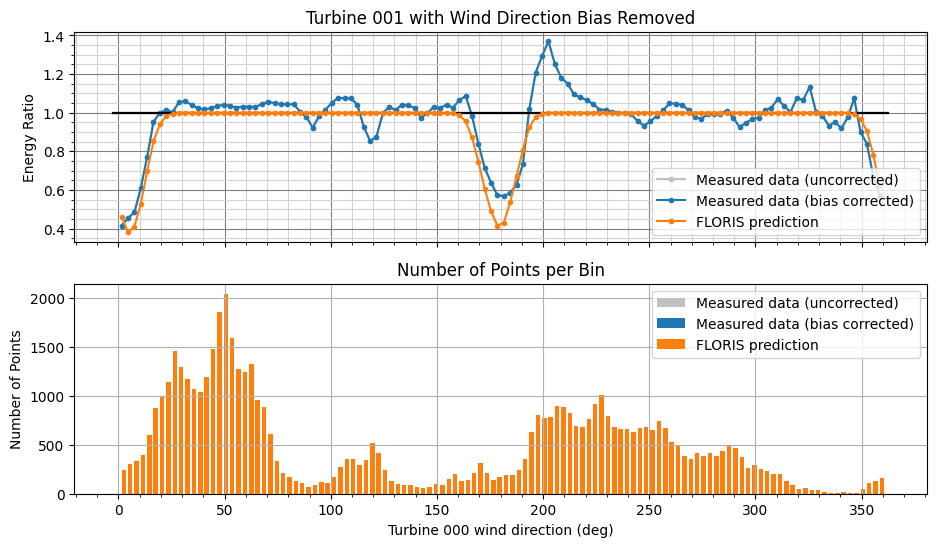

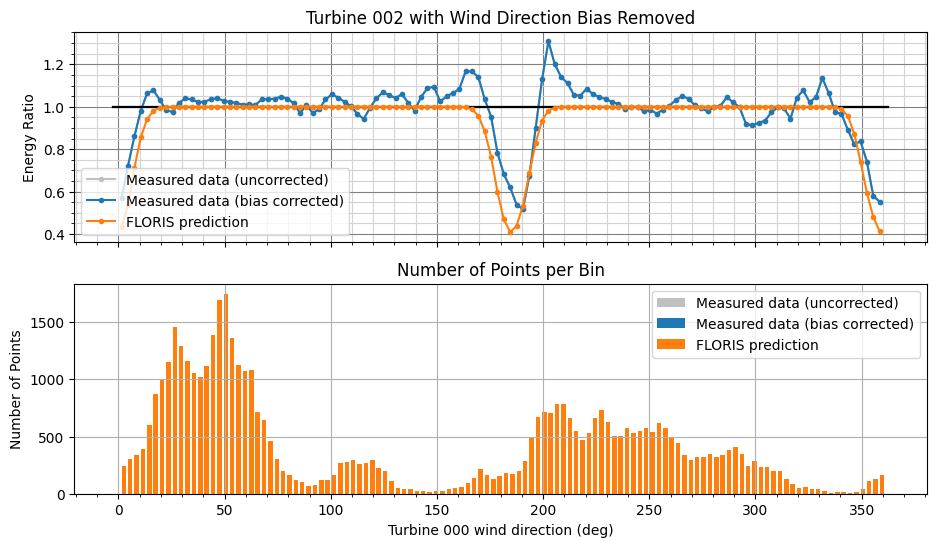

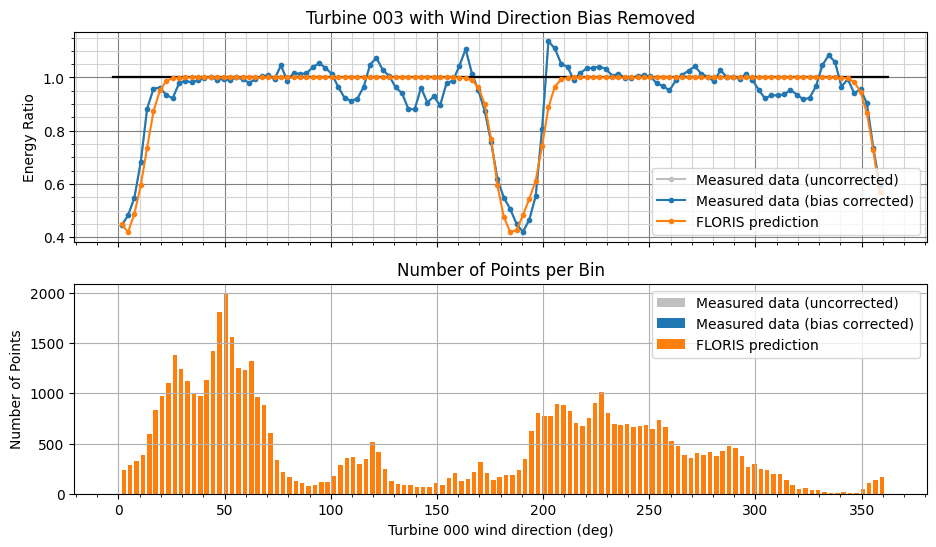

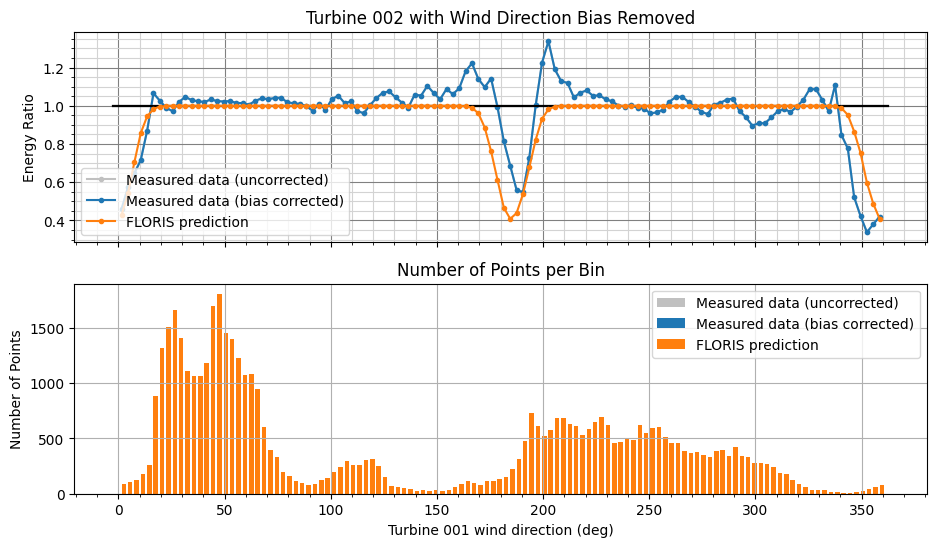

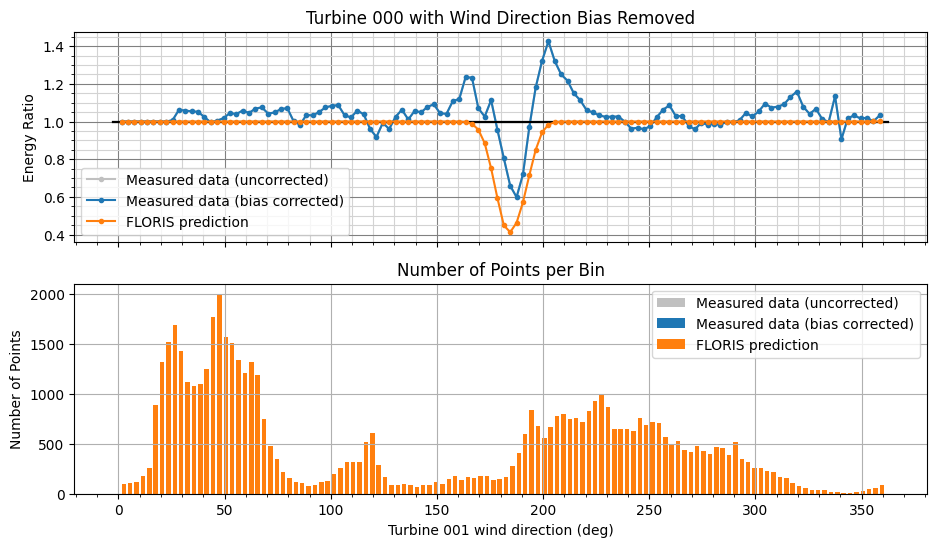

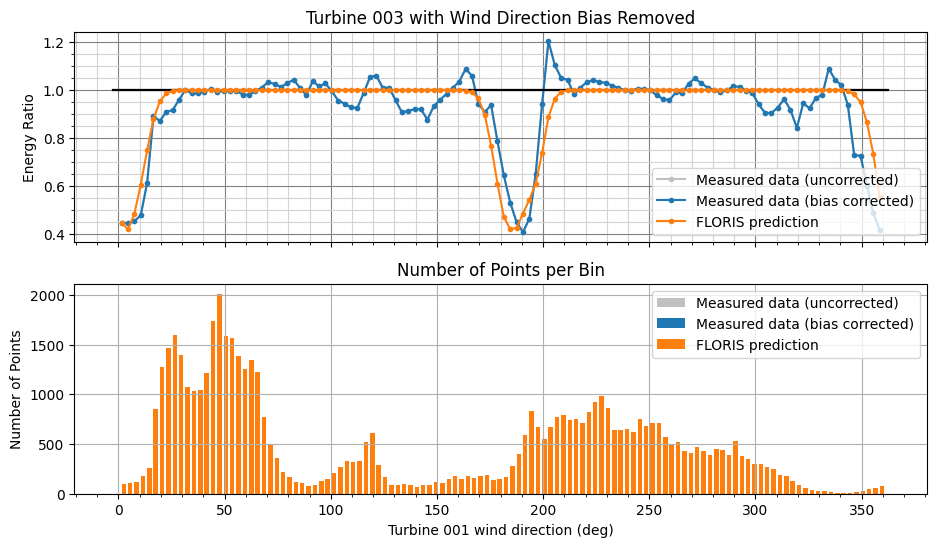

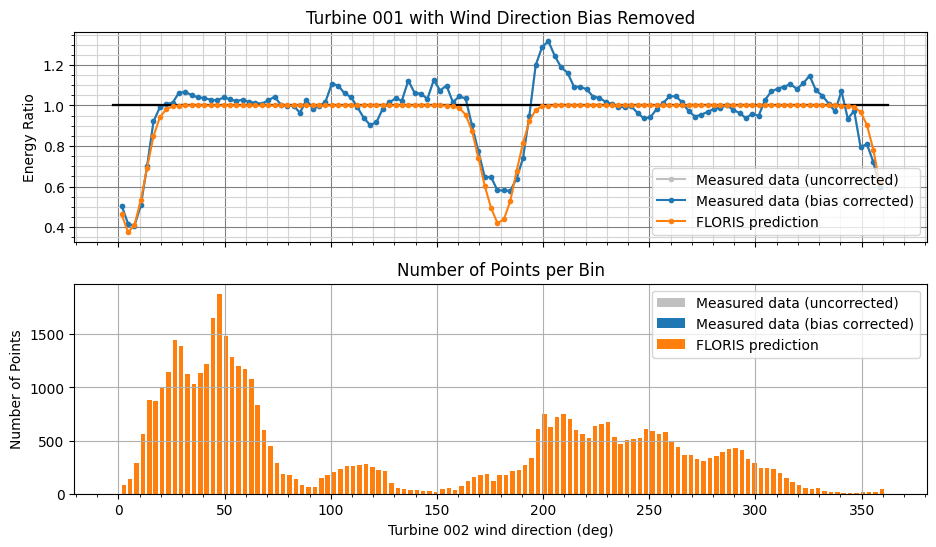

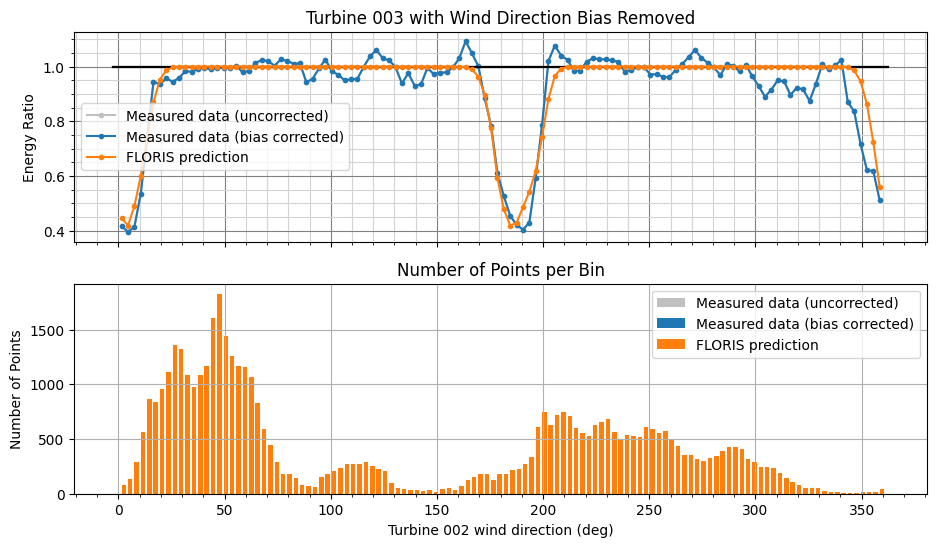

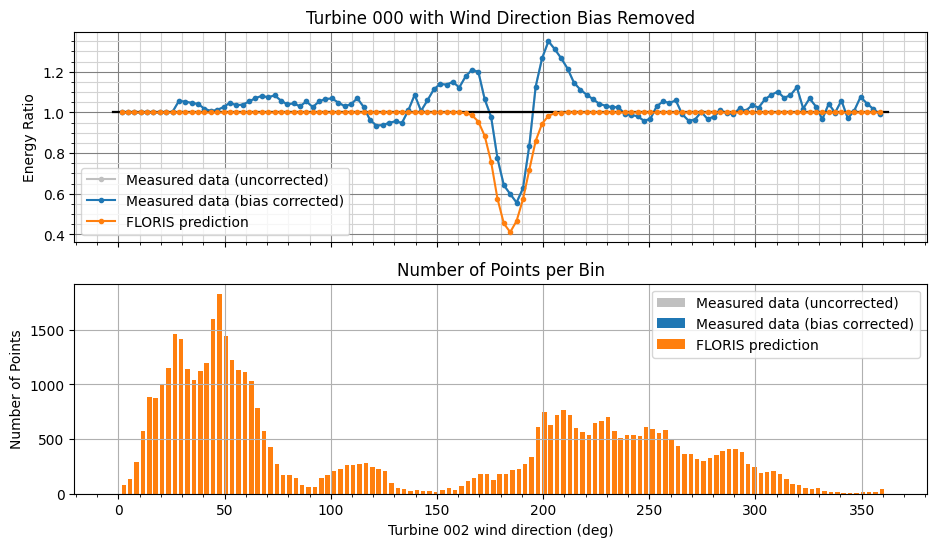

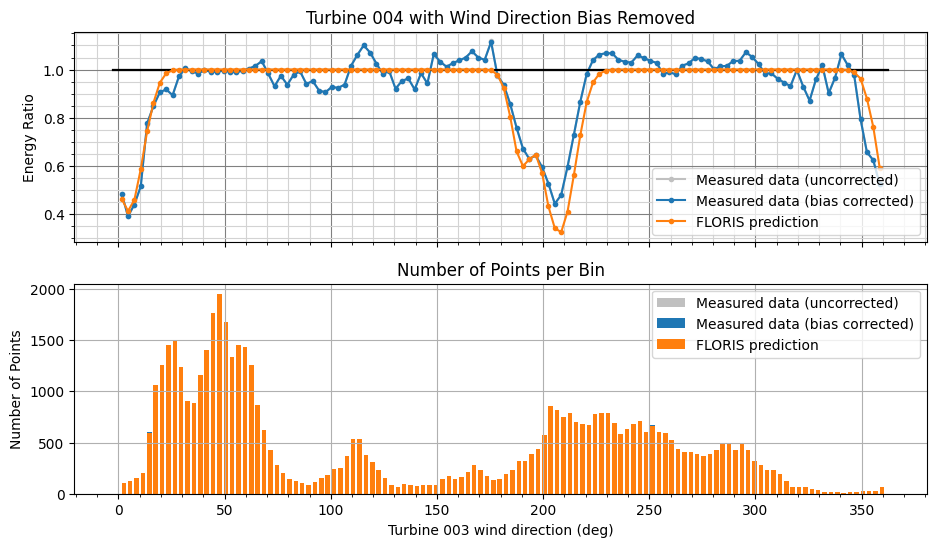

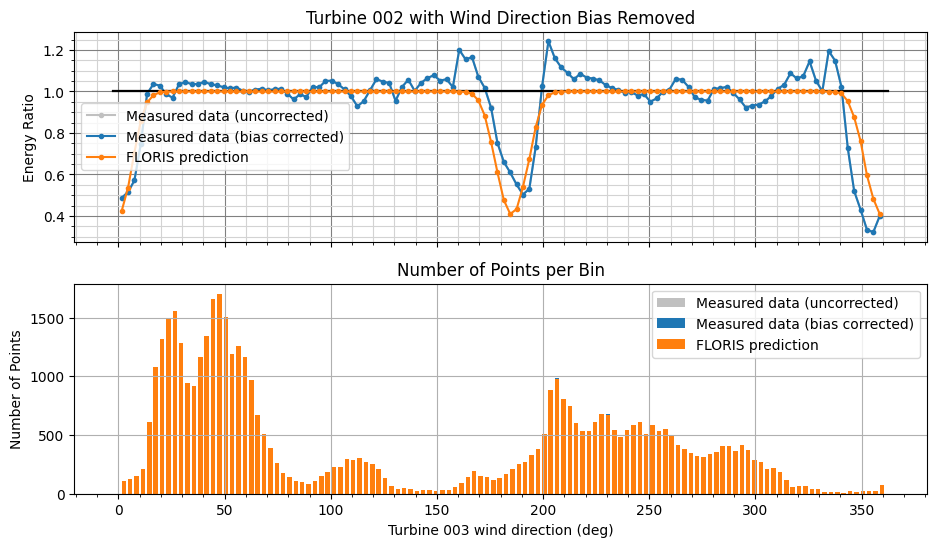

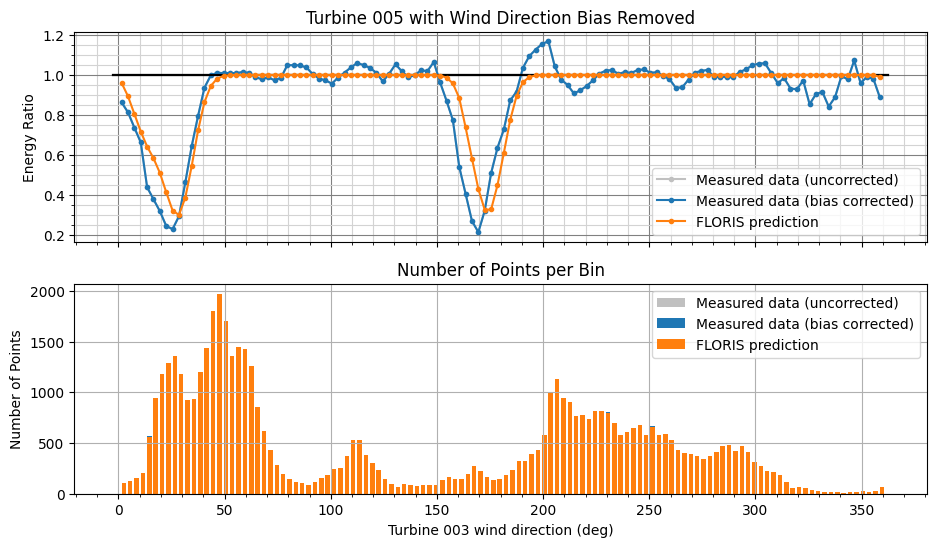

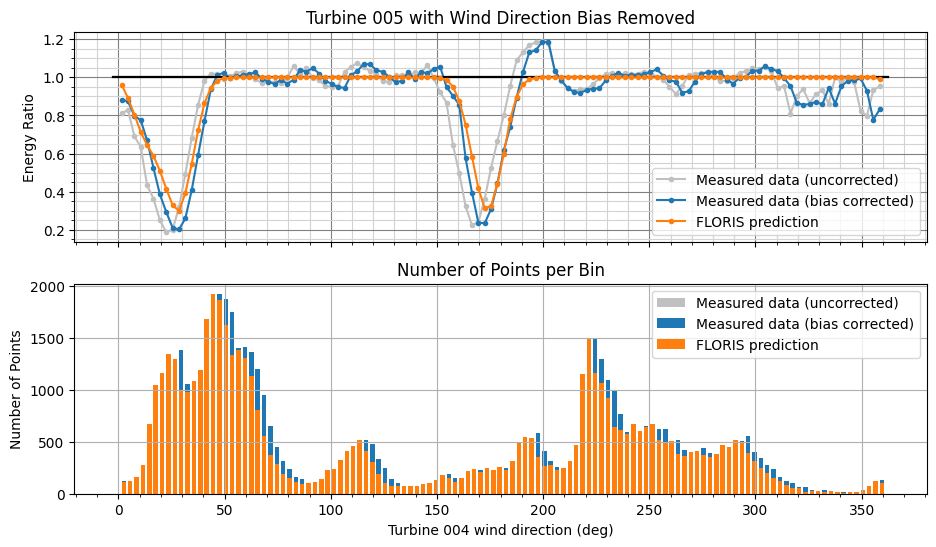

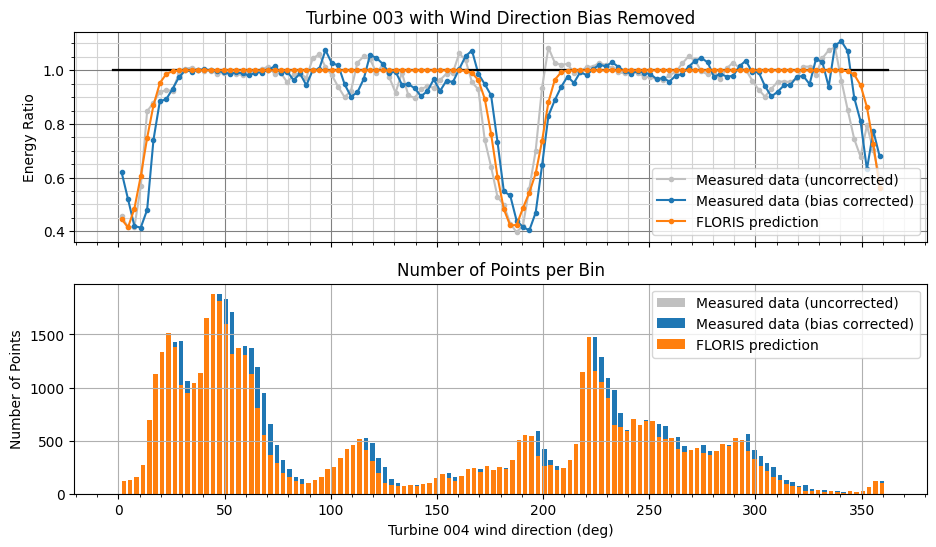

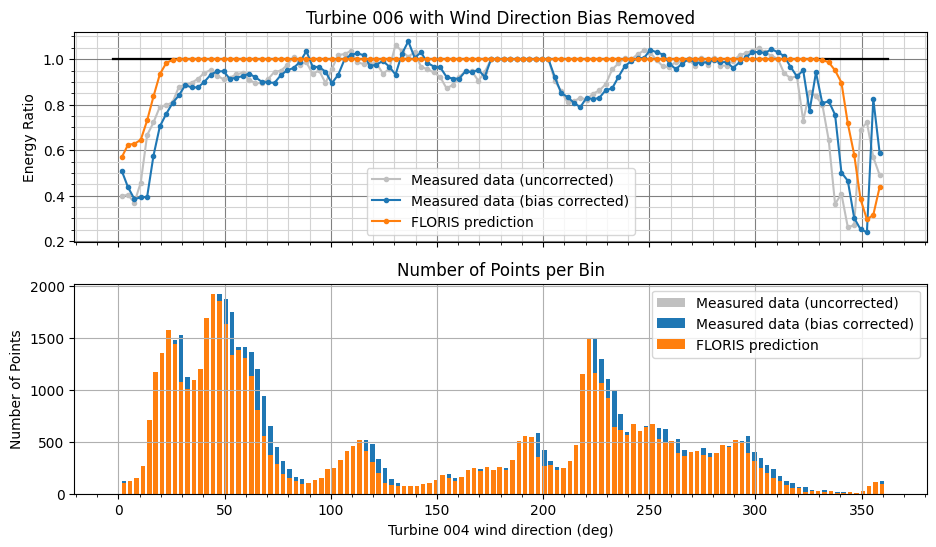

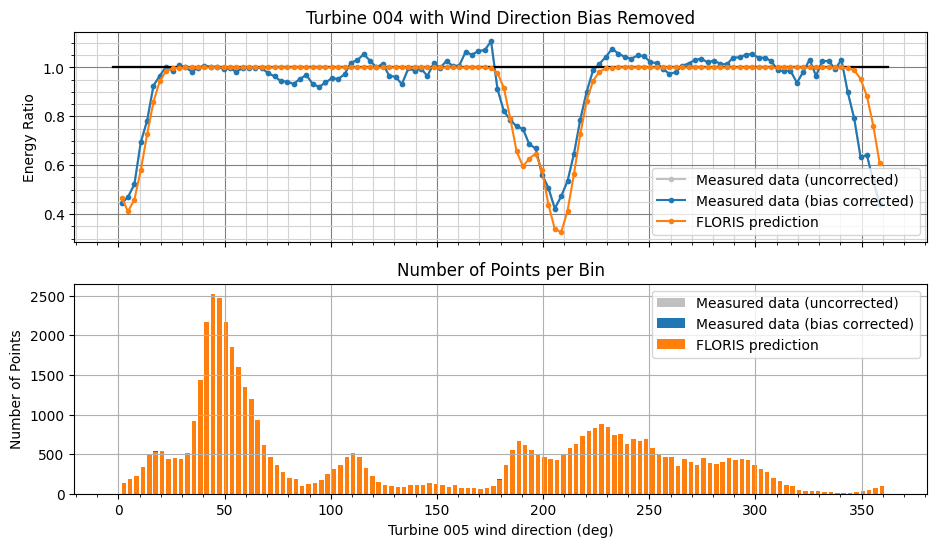

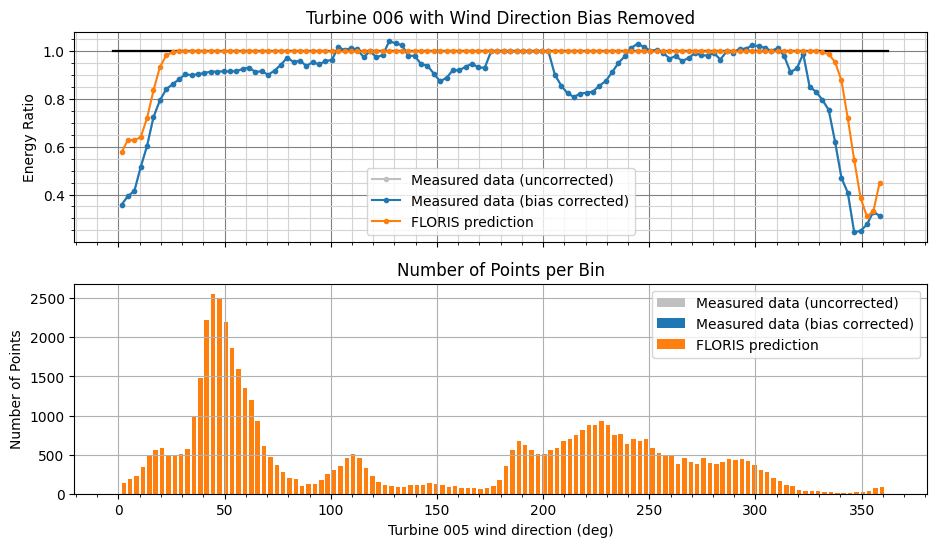

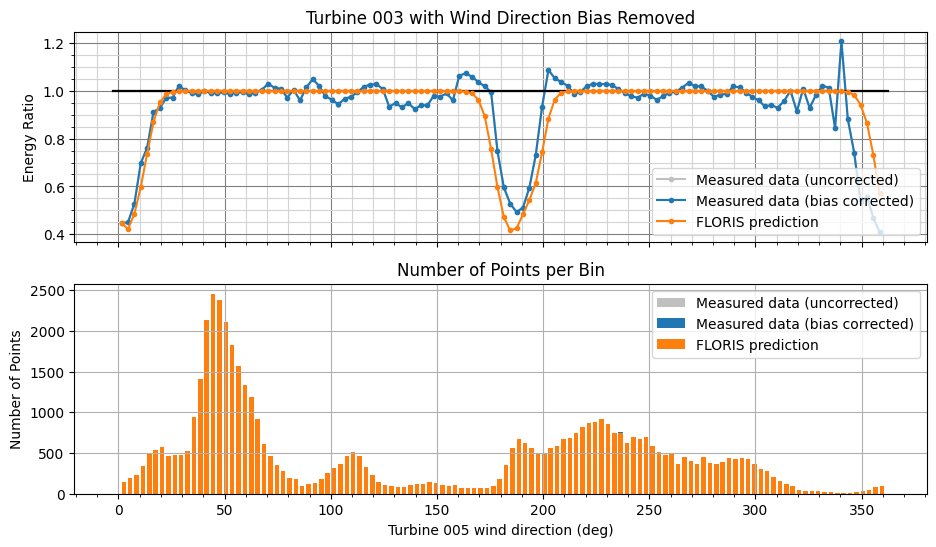

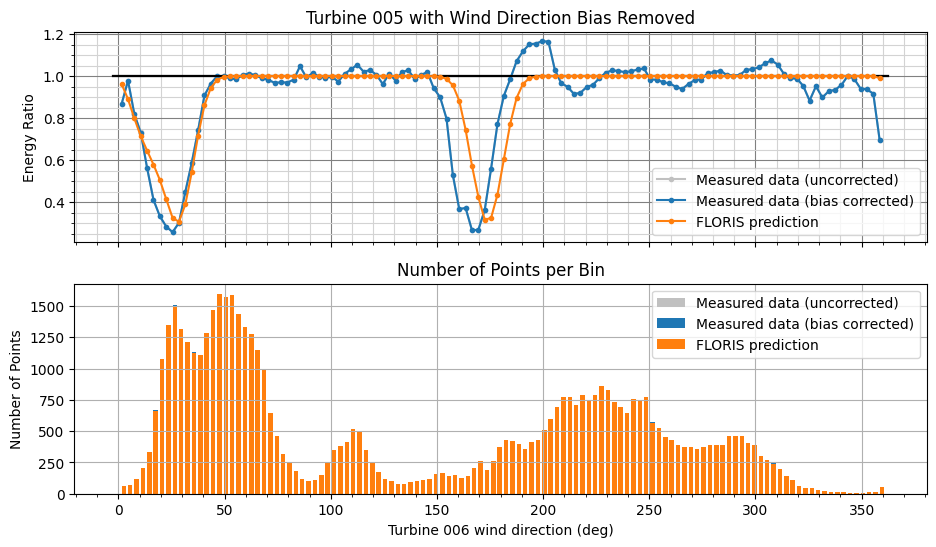

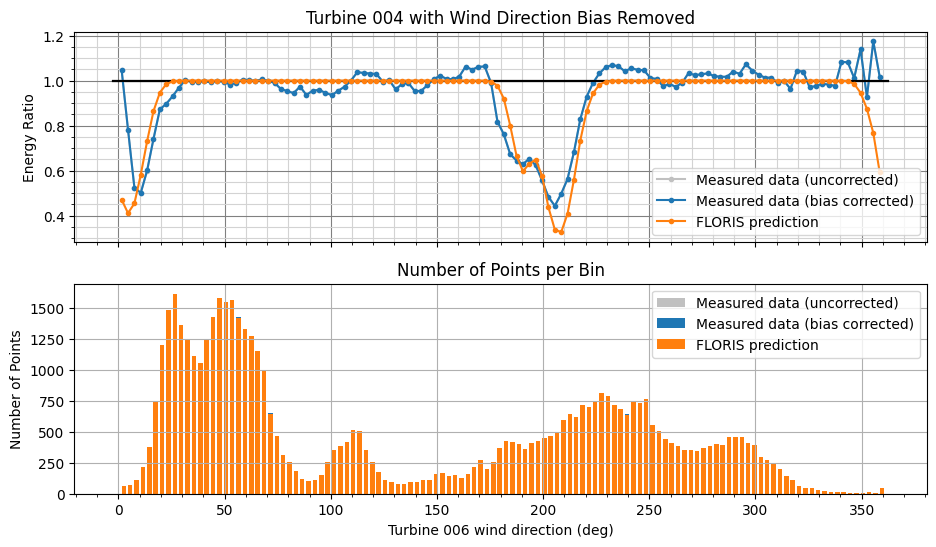

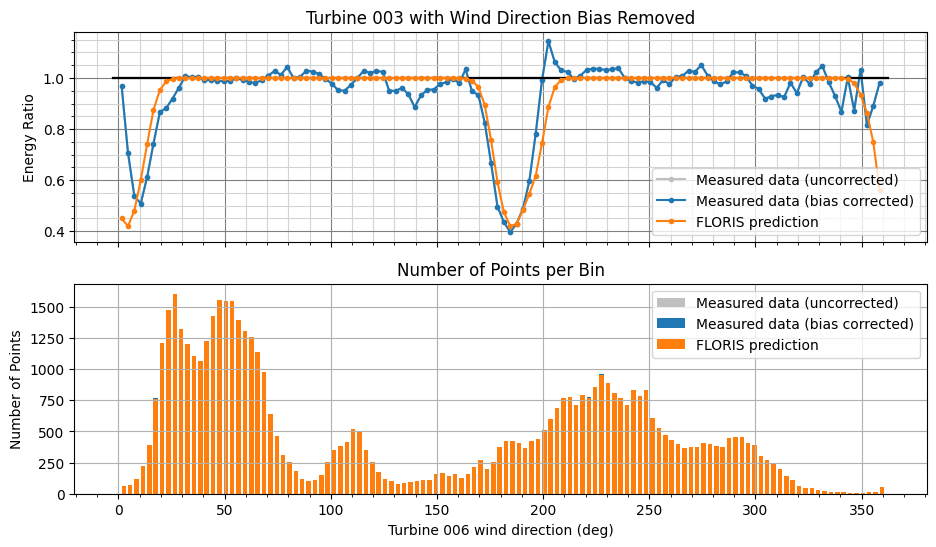

In [8]:
def estimate_biases_with_reference_wd(df_scada, fm, wd_ref):
    # Now use this knowledge to estimate bias for every turbine
    num_turbines = len(fm.layout_x)
    wd_bias_list = np.zeros(num_turbines)

    for ti in range(num_turbines):
        # Calculate the offset between this turbine's wind direction and that
        # of the calibrated (reference) wind direction. Note that 'wd_ref' may
        # also be a met mast' wind direction signal, if available. The offset
        # between a turbine's wind direction and wd_ref is very likely to be
        # the bias or close to the bias in this turbine's northing.
        wd_test = df_scada["wd_{:03d}".format(ti)]
        x0, _ = flopt.match_y_curves_by_offset(
            wd_ref, wd_test, dy_eval=np.arange(-180.0, 180.0, 2.0), angle_wrapping=True
        )

        # Then, we refine this first guess by evaluating the cost function
        # at [-5.0, 0.0, 5.0] deg around x0, and let the optimizer
        # converge.
        x_search_bounds = np.round(x0) + np.array([-5.0, 5.0])

        # Calculate and save the results to a list
        wd_bias_list[ti] = get_bias_for_single_turbine(
            df=df_scada,
            fm=fm,
            ti=ti,
            opt_search_range=x_search_bounds,
            plot=True,
            figure_save_path=None,
        )
        print(" ")

    return wd_bias_list


wd_bias_list = estimate_biases_with_reference_wd(df_scada_marked_faulty_northing_drift, fm, wd_ref)
print("Wind direction biases: {}".format(wd_bias_list))

# **Step 5**: Correct turbine wind directions for bias
The next step is to apply the estimated northing corrections to the turbines' wind direction signals.

In [9]:
def apply_bias_corrections(df_scada, wd_bias_list):
    # Copy dataframe
    df_out = df_scada.copy()

    # Load the SCADA data
    num_turbines = dfm.get_num_turbines(df_scada)

    # Set turbine-individual bias corrections
    for ti in range(num_turbines):
        bias = wd_bias_list[ti]
        print("Removing {:.2f} deg bias for ti = {:03d}.".format(bias, ti))
        df_out["wd_{:03d}".format(ti)] = wrap_360(df_out["wd_{:03d}".format(ti)] - bias)

    return df_out


# Get bias corrections
print("wd_bias_list: {}".format(wd_bias_list))
df_scada_northing_calibrated = apply_bias_corrections(
    df_scada=df_scada_marked_faulty_northing_drift.copy(), wd_bias_list=wd_bias_list
)

wd_bias_list: [ 0.000e+00  0.000e+00  0.000e+00  2.500e-04 -4.375e+00  2.500e-04
  2.500e-04]
Removing 0.00 deg bias for ti = 000.
Removing 0.00 deg bias for ti = 001.
Removing 0.00 deg bias for ti = 002.
Removing 0.00 deg bias for ti = 003.
Removing -4.38 deg bias for ti = 004.
Removing 0.00 deg bias for ti = 005.
Removing 0.00 deg bias for ti = 006.


As shown above, the only correction made was subtracting the estimated northing bias of -4.38 degrees from the wind direction signal of turbine 004 (i.e., adding 4.38 degrees to the wind direction).

# **Step 6**: Deal with inter-turbine faults
In this step, we will deal with faults (i.e., abnormal power production based on the curtailment and power curve filtering operations in the previous example notebook) at one turbine causing issues at another turbine. For example, if a turbine is shedding a wake on a second turbine, then for a fair comparison both of these two turbines should be operating normally. If the upstream turbine is curtailed or offline, the power production of the downstream turbine will also be affected. Hence, if we are unsure about the operating mode of one machine, we cannot make accurate FLORIS predictions on the second turbine either. To address this, we will classify waked turbines' measurements as faulty if any upstream turbine from which they are waked is faulty.

In [10]:
def filter_for_faults_in_impacting_turbines(df):
    # Determine which turbines impact which other turbines through their wakes
    print("Calculating the 'df_impacting_turbines' matrix...")
    df_impacting_turbines = ftools.get_all_impacting_turbines(
        fm_in=fm,
        wd_array=np.arange(0.0, 360.0, 3.0),
        change_threshold=0.005,
        ws_test=9.0,
    )
    print(df_impacting_turbines)

    # Filter the measurements for each turbine: make sure
    #  all other turbines affecting this turbine's
    # power production are marked as good measurements.
    # If they are not, then classify this turbine's
    # measurement as faulty too.
    num_turbines = dfm.get_num_turbines(df)
    for ti in range(num_turbines):
        # Assign a reference wind direction for this turbine. In this case,
        # we have such a small farm so we assume that the farm average wind
        # direction of representative of every turbine.
        df = dfm.set_wd_by_all_turbines(df)

        df_scada = filt.filter_df_by_faulty_impacting_turbines(
            df=df,
            ti=ti,
            df_impacting_turbines=df_impacting_turbines,
            verbose=True,
        )

    return df_scada


df_scada_northing_calibrated_interturbine_filtered = filter_for_faults_in_impacting_turbines(
    df=df_scada_northing_calibrated.copy()
)

Calculating the 'df_impacting_turbines' matrix...


floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.
floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.
floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.
floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.
floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.
floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.
floris.floris_model.FlorisModel WARNING Deleting stored wind_data information.


        0    1       2          3             4                5  \
wd                                                                 
0.0    []  [0]  [1, 0]  [2, 1, 0]  [3, 1, 2, 0]           [1, 0]   
3.0    []  [0]  [1, 0]  [2, 0, 1]     [3, 0, 1]           [1, 0]   
6.0    []  [0]  [1, 0]     [2, 1]        [3, 1]     [1, 0, 2, 3]   
9.0    []  [0]  [1, 0]     [2, 1]     [3, 1, 2]     [2, 3, 0, 1]   
12.0   []  [0]  [1, 0]     [2, 1]        [3, 2]  [3, 1, 2, 4, 0]   
...    ..  ...     ...        ...           ...              ...   
345.0  []   []     [1]         []            []               []   
348.0  []  [0]  [1, 0]        [2]           [3]               []   
351.0  []  [0]  [1, 0]     [2, 1]        [3, 2]               []   
354.0  []  [0]  [1, 0]  [2, 1, 0]     [3, 2, 1]               []   
357.0  []  [0]  [1, 0]     [2, 1]     [3, 1, 0]               []   

                        6  
wd                         
0.0                   [5]  
3.0       [5, 4, 3, 1, 2]  
6.0

2024-04-09 14:26:35 Faulty measurements for WTG 00 increased from 19.068 % to 19.826 %. Reason: 'Turbine is impacted by faulty upstream turbine'.
2024-04-09 14:26:35 Faulty measurements for WTG 01 increased from 21.065 % to 22.041 %. Reason: 'Turbine is impacted by faulty upstream turbine'.
2024-04-09 14:26:36 Faulty measurements for WTG 02 increased from 31.555 % to 31.902 %. Reason: 'Turbine is impacted by faulty upstream turbine'.
2024-04-09 14:26:36 Faulty measurements for WTG 03 increased from 24.499 % to 25.165 %. Reason: 'Turbine is impacted by faulty upstream turbine'.
2024-04-09 14:26:36 Faulty measurements for WTG 04 increased from 20.425 % to 21.772 %. Reason: 'Turbine is impacted by faulty upstream turbine'.
2024-04-09 14:26:37 Faulty measurements for WTG 05 increased from 22.681 % to 25.979 %. Reason: 'Turbine is impacted by faulty upstream turbine'.
2024-04-09 14:26:37 Faulty measurements for WTG 06 increased from 20.142 % to 21.164 %. Reason: 'Turbine is impacted by faul

# **Step 7**: Save the processed data
Lastly, we'll save the wind direction bias-corrected dataframe to our local path folder for use in further data analysis steps (e.g., model validation, wake loss estimation, turbine monitoring).

In [11]:
# Save the dataframe with corrected wind directions
print("Saving dataframes as .ftr files")
fout = root_path / "postprocessed" / "df_scada_data_60s_filtered_and_northing_calibrated.ftr"
df_scada_northing_calibrated_interturbine_filtered.to_feather(fout)
print(f"Finished processing. Saved the df as {fout}.")

Saving dataframes as .ftr files
Finished processing. Saved the df as /Users/pfleming/Projects/FLASC/flasc/examples_smarteole/postprocessed/df_scada_data_60s_filtered_and_northing_calibrated.ftr.
